In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import concurrent.futures

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 12})

In [3]:
def compute_values(mu_V_ratio, J_V_ratio, V, N, M, states, chemical_potential_loc = 0):
    """Compute energy gap for given parameters."""
    H = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio, chemical_potential_loc = chemical_potential_loc)
    eigenvalues, eigenvectors = exact_diagonalize(H)
    energy_gap = eigenvalues[1] - eigenvalues[0]
    second_energy_gap = eigenvalues[2] - eigenvalues[0]
    return energy_gap, second_energy_gap

def create_energy_gap_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0, 2), resolution = 100, chemical_potential_loc = 1):
    
    min_J_V_ratio = J_bounds[0]
    max_J_V_ratio = J_bounds[1]
    max_mu_V_ratio = mu_bounds[1]
    
    mu_V_ratios = np.linspace(0, max_mu_V_ratio, resolution)
    J_V_ratios = np.linspace(min_J_V_ratio, max_J_V_ratio, resolution)
    mu_V_ratio_grid, J_V_ratio_grid = np.meshgrid(mu_V_ratios, J_V_ratios)

    energy_gap_over_V_grid = np.zeros_like(mu_V_ratio_grid)
    second_energy_gap_over_V_grid = np.zeros_like(mu_V_ratio_grid)
    states, _ = enumerate_states(N, M)

    # Use ThreadPoolExecutor for parallel processing
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_index = {}
        
        for i, mu_V_ratio in enumerate(mu_V_ratios):
            for j, J_V_ratio in enumerate(J_V_ratios):
                future = executor.submit(compute_values, mu_V_ratio, J_V_ratio, V, N, M, states, chemical_potential_loc)
                future_to_index[future] = (j, i)
        
        for future in concurrent.futures.as_completed(future_to_index):
            j, i = future_to_index[future]
            try:
                energy_gaps = future.result()
                energy_gap = energy_gaps[0]
                second_energy_gap = energy_gaps[1]
                
                energy_gap_over_V_grid[j, i] = energy_gap
                second_energy_gap_over_V_grid[j, i] = second_energy_gap
            except Exception as e:
                print(f"Error computing values for indices ({j}, {i}): {e}")

    J_V_ratios_full = np.concatenate((-J_V_ratios[::-1], J_V_ratios))  # mirroring data for J/V > 0 
    mu_V_ratios_full = mu_V_ratios
    J_V_ratio_grid_full, mu_V_ratio_grid_full = np.meshgrid(J_V_ratios_full, mu_V_ratios_full)
    energy_gap_full = np.concatenate((energy_gap_over_V_grid[::-1, :], energy_gap_over_V_grid), axis=0)
    second_energy_gap_full = np.concatenate((second_energy_gap_over_V_grid[::-1, :], second_energy_gap_over_V_grid), axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, energy_gap_full, cmap="plasma", shading="auto")
    fig.colorbar(c, ax=ax, label="$\Delta E / |V|$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"Energy Gap: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, np.log(1/energy_gap_full), cmap="plasma", shading="auto", vmin = 0.1, vmax = 10)
    fig.colorbar(c, ax=ax, label="log$[|V| / \Delta E]$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"Log Inverse Energy Gap: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()
    
    """fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, second_energy_gap_full, cmap="plasma", shading="auto")
    fig.colorbar(c, ax=ax, label="$\Delta E / |V|$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"2nd Energy Gap: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()"""
    
    """fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, np.log(1/second_energy_gap_full), cmap="plasma", shading="auto")
    fig.colorbar(c, ax=ax, label="log$[\Delta E / |V|]$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"Log Inverse 2nd Energy Gap: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()"""

def compute_sigma_value(mu_V_ratio, J_V_ratio, V, N, M, states, chemical_potential_loc = 0):
    """Compute energy gap for given parameters."""
    H = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio, chemical_potential_loc = chemical_potential_loc)
    eigenvalues, eigenvectors = exact_diagonalize(H)
    ground_state = eigenvectors[0]
    states, _ = enumerate_states(N,M)
    
    if N == 2:
        sigma = sigma_ij(0, 1, ground_state, states, N, M)

    else:
        sigma = sigma_ij(N//2, N//2+1, ground_state, states, N, M)
    normalized_sigma = sigma/M
    return normalized_sigma, sigma

def create_sigma_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0, 2), resolution = 100, chemical_potential_loc = 1):
    
    min_J_V_ratio = J_bounds[0]
    max_J_V_ratio = J_bounds[1]
    max_mu_V_ratio = mu_bounds[1]
    
    mu_V_ratios = np.linspace(0, max_mu_V_ratio, resolution)
    J_V_ratios = np.linspace(min_J_V_ratio, max_J_V_ratio, resolution)
    mu_V_ratio_grid, J_V_ratio_grid = np.meshgrid(mu_V_ratios, J_V_ratios)

    normalized_sigma_grid = np.zeros_like(mu_V_ratio_grid)
    sigma_grid = np.zeros_like(mu_V_ratio_grid)
    states, _ = enumerate_states(N, M)

    # Use ThreadPoolExecutor for parallel processing
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_index = {}
        
        for i, mu_V_ratio in enumerate(mu_V_ratios):
            for j, J_V_ratio in enumerate(J_V_ratios):
                future = executor.submit(compute_sigma_value, mu_V_ratio, J_V_ratio, V, N, M, states, chemical_potential_loc)
                future_to_index[future] = (j, i)
        
        for future in concurrent.futures.as_completed(future_to_index):
            j, i = future_to_index[future]
            try:
                results = future.result()
                normalized_sigma = results[0]
                sigma = results[1]
                
                normalized_sigma_grid[j, i] = normalized_sigma
                sigma_grid[j, i] = sigma
            except Exception as e:
                print(f"Error computing values for indices ({j}, {i}): {e}")

    J_V_ratios_full = np.concatenate((-J_V_ratios[::-1], J_V_ratios))  # mirroring data for J/V > 0 
    mu_V_ratios_full = mu_V_ratios
    J_V_ratio_grid_full, mu_V_ratio_grid_full = np.meshgrid(J_V_ratios_full, mu_V_ratios_full)
    normalized_sigma_full = np.concatenate((normalized_sigma_grid[::-1, :], normalized_sigma_grid), axis=0)
    sigma_full = np.concatenate((sigma_grid[::-1, :], sigma_grid), axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, normalized_sigma_full, cmap="plasma", shading="auto")
    fig.colorbar(c, ax=ax, label="$\sigma/M$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"$\sigma/M$: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()
    
"""    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, sigma_full, cmap="plasma", shading="auto")
    fig.colorbar(c, ax=ax, label="\sigma$")
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel("$μ/|V|$")
    ax.set_title(f"$\sigma$: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")
    fig.tight_layout()
    plt.show()"""

'    fig, ax = plt.subplots(figsize=(8, 6))\n    c = ax.pcolormesh(J_V_ratio_grid_full.T, mu_V_ratio_grid_full.T, sigma_full, cmap="plasma", shading="auto")\n    fig.colorbar(c, ax=ax, label="\\sigma$")\n    ax.set_xlabel("$J/|V|$")\n    ax.set_ylabel("$μ/|V|$")\n    ax.set_title(f"$\\sigma$: N = {N}, M = {M}, V = {V} [μ @ m = {chemical_potential_loc}]")\n    fig.tight_layout()\n    plt.show()'

In [4]:
"""import numpy as np
import matplotlib.pyplot as plt

def compute_energy_gap_grid(N, M, V, mu_bounds=(0, 3), J_bounds=(-3, 3), resolution=250, chemical_potential_loc=1):
    mu_vals = np.linspace(mu_bounds[0], mu_bounds[1], resolution)
    J_vals = np.linspace(J_bounds[0], J_bounds[1], resolution)
    energy_gap = np.zeros((resolution, resolution))

    states, _ = enumerate_states(N, M)

    for i, mu in enumerate(mu_vals):
        for j, J in enumerate(J_vals):
            gap, _ = compute_values(mu, J, V, N, M, states, chemical_potential_loc)
            energy_gap[i, j] = gap  # rows = mu, cols = J

    return energy_gap

# Parameters
Ns = [2]
Ms = [3]
V = -1

fig, axes = plt.subplots(3, 3, figsize=(8, 8), constrained_layout=True)
global_min, global_max = float('inf'), float('-inf')
gap_data = {}

# Precompute all gap arrays
for i, N in enumerate(Ns):
    for j, M in enumerate(Ms):
        gap = compute_energy_gap_grid(N, M, V, mu_bounds=(0, 3), J_bounds=(-3, 3))
        log_gap = np.log(1 / gap) 
        gap_data[(i, j)] = log_gap
        global_min = 0.1 #min(global_min, log_gap.min())
        global_max = 10  #max(global_max, log_gap.max())

# Plot each subplot
for i, N in enumerate(Ns):
    for j, M in enumerate(Ms):
        ax = axes[i, j]
        log_gap = gap_data[(i, j)]
        im = ax.imshow(log_gap, origin='lower',
                    extent=(-3, 3, 0, 3), aspect='auto',
                    vmin=global_min, vmax=global_max, cmap='plasma')


        # Ticks only on outer edges
        if i == 2:
            ax.set_xlabel("$J/|V|$", fontsize=10)
            ax.set_xticks([-3, -1.5, 0, 1.5, 3])
        else:
            ax.set_xticks([])

        if j == 0:
            ax.set_ylabel("$μ/|V|$", fontsize=10)
            ax.set_yticks([0, 1.5, 3])
        else:
            ax.set_yticks([])

        # Optional: Annotate (N, M) in corner
        ax.text(-2.8, 2.7, f"N={N}, M={M}", fontsize=7, color='white')

# Shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="log($|V|/\Delta E$)")

#plt.suptitle("Energy Gap vs μ/V and J/V for Different (N, M)", fontsize=14)
plt.show()
"""

'import numpy as np\nimport matplotlib.pyplot as plt\n\ndef compute_energy_gap_grid(N, M, V, mu_bounds=(0, 3), J_bounds=(-3, 3), resolution=250, chemical_potential_loc=1):\n    mu_vals = np.linspace(mu_bounds[0], mu_bounds[1], resolution)\n    J_vals = np.linspace(J_bounds[0], J_bounds[1], resolution)\n    energy_gap = np.zeros((resolution, resolution))\n\n    states, _ = enumerate_states(N, M)\n\n    for i, mu in enumerate(mu_vals):\n        for j, J in enumerate(J_vals):\n            gap, _ = compute_values(mu, J, V, N, M, states, chemical_potential_loc)\n            energy_gap[i, j] = gap  # rows = mu, cols = J\n\n    return energy_gap\n\n# Parameters\nNs = [2]\nMs = [3]\nV = -1\n\nfig, axes = plt.subplots(3, 3, figsize=(8, 8), constrained_layout=True)\nglobal_min, global_max = float(\'inf\'), float(\'-inf\')\ngap_data = {}\n\n# Precompute all gap arrays\nfor i, N in enumerate(Ns):\n    for j, M in enumerate(Ms):\n        gap = compute_energy_gap_grid(N, M, V, mu_bounds=(0, 3), J_bo

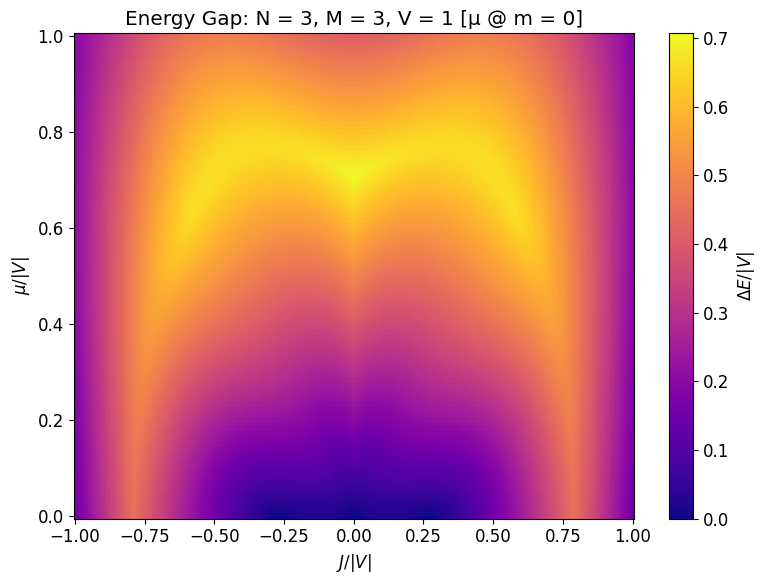

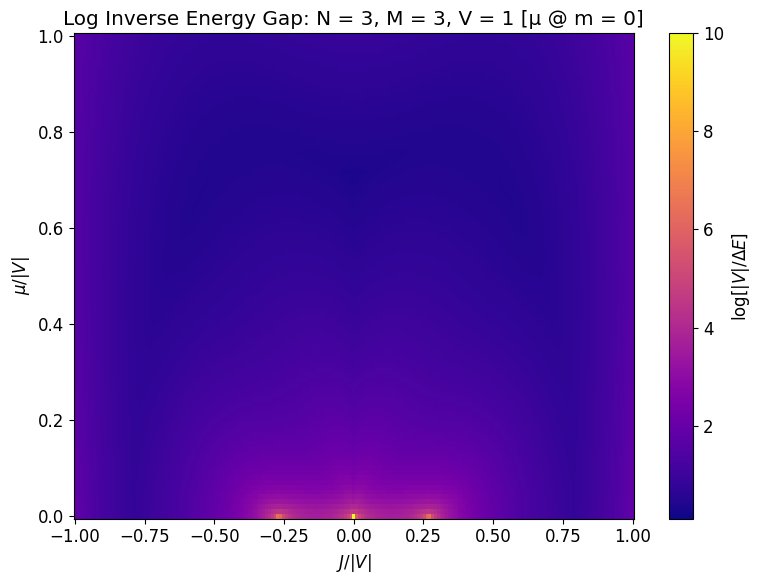

In [5]:
Ns = [3]
Ms = [3]
V = 1
for N in Ns:
    for M in Ms:
        create_energy_gap_plot(N, M, V, mu_bounds = (0,1), J_bounds = (0,1), resolution = 100, chemical_potential_loc = 0)


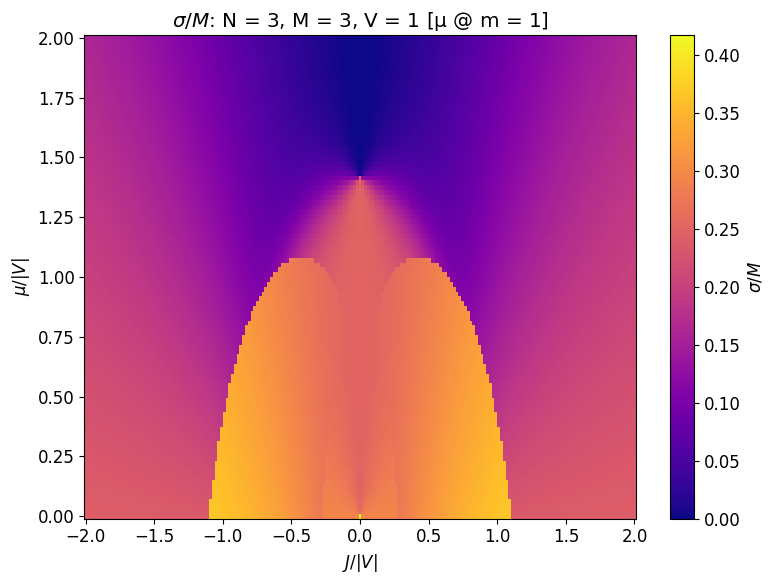

In [6]:
Ns = [3]
Ms = [3]
V = 1
for N in Ns:
    for M in Ms:
        create_sigma_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0,2), resolution = 100, chemical_potential_loc = 1)


In [7]:
"""N = 2
V = 1
for M in range(2,10):
    create_sigma_plot(N, M, V, mu_bounds = (0,3), J_bounds = (0,3), chemical_potential_loc = 0, resolution = 100)"""

'N = 2\nV = 1\nfor M in range(2,10):\n    create_sigma_plot(N, M, V, mu_bounds = (0,3), J_bounds = (0,3), chemical_potential_loc = 0, resolution = 100)'

In [8]:
"""for N in [2,3,4]:
    for M in [2,3,4]:
        for V in [1,-1]:
            for chemical_potential_loc in range(0, M//2 + 1):
                create_energy_gap_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0,2), chemical_potential_loc = chemical_potential_loc, resolution = 250)"""

'for N in [2,3,4]:\n    for M in [2,3,4]:\n        for V in [1,-1]:\n            for chemical_potential_loc in range(0, M//2 + 1):\n                create_energy_gap_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0,2), chemical_potential_loc = chemical_potential_loc, resolution = 250)'

In [9]:
"""for N in [3]:
    for M in [5]:
        for V in [1]:
            for chemical_potential_loc in range(0, M//2 + 1):
                create_energy_gap_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0,2), chemical_potential_loc = chemical_potential_loc, resolution = 100)"""

'for N in [3]:\n    for M in [5]:\n        for V in [1]:\n            for chemical_potential_loc in range(0, M//2 + 1):\n                create_energy_gap_plot(N, M, V, mu_bounds = (0,2), J_bounds = (0,2), chemical_potential_loc = chemical_potential_loc, resolution = 100)'